In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.signal import find_peaks
import yfinance as yf



In [8]:

def load_data(symbol, start_date=None):

    if symbol == 'BTC-USD':
        historical_data_btc = pd.read_csv('historical_btc.csv')
        historical_data_btc['date'] = pd.to_datetime(historical_data_btc['date'])
        last_date = historical_data_btc['date'].max()
        new_data_btc = yf.download(symbol, start=start_date) if start_date else yf.download(symbol, start='1970-01-01')
        new_data_btc = new_data_btc.reset_index()
        new_data_btc = new_data_btc[['Date', 'Close']]
        new_data_btc.columns = ['date', 'btc_price']
        full_data = pd.concat([historical_data_btc, new_data_btc], axis=0)
        full_data = full_data.sort_values('date')
        full_data = full_data[full_data['date'] >= start_date] if start_date else full_data
        full_data['date'] = pd.to_datetime(full_data['date'])
        # we remove dates before start_date

        full_data = full_data.reset_index(drop=False)
        max_date = full_data['date'].max()
        print('Max date loaded:', max_date)
    else:
        new_data_btc = yf.download(symbol, start=start_date)
        new_data_btc = new_data_btc.reset_index()
        new_data_btc = new_data_btc[['Date', 'Close']]
        new_data_btc.columns = ['date', 'btc_price']
        full_data = new_data_btc
        full_data = full_data.sort_values('date')
        full_data = full_data.reset_index(drop=False)
        full_data['date'] = pd.to_datetime(full_data['date'])
        max_date = full_data['date'].max()
        print('Max date loaded:', max_date)

    if symbol == 'SPY':
        full_data['btc_price'] = full_data['btc_price'] * 10   

    return full_data



In [11]:
historical_data = load_data('BTC-USD')
historical_data.head()


c:\Github\repos\swanhunt\.conda\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed

Max date loaded: 2024-06-01 00:00:00


,index,date,btc_price
0,0,2009-10-05,0.000764
1,1,2009-10-06,0.000885
2,2,2009-10-07,0.001050
3,3,2009-10-08,0.001084
4,4,2009-10-09,0.001200


In [59]:
from scipy.signal import find_peaks
import numpy as np

def get_peaks(full_data, d_days, threshold):
    full_data = full_data[['date', 'btc_price']].copy()
    full_data.reset_index(drop=True, inplace=True)
    print('Getting peaks')
    
    # Find initial peaks with a specified distance
    peaks, _ = find_peaks(full_data['btc_price'], distance=d_days)
    clean_peaks = []
    
    if len(peaks) > 0:
        # First pass to identify initial peaks
        for i, peak in enumerate(peaks):
            if not any(full_data['btc_price'][peak] < full_data['btc_price'][past_peak] for past_peak in peaks[:i]):
                if peak + 1 < len(full_data):
                    right_side = full_data['btc_price'][peak + 1:]
                    if len(right_side) > 0 and (right_side < (full_data['btc_price'][peak] * (1 - threshold))).any():
                        clean_peaks.append(peak)
    
    clean_peaks = np.array(clean_peaks)
    
    # Enforce one peak per d_days using a backwards window
    final_peaks = []
    if len(clean_peaks) > 0:
        final_peaks.append(clean_peaks[0])
        for i in range(1, len(clean_peaks)):
            if clean_peaks[i] - final_peaks[-1] >= d_days:
                final_peaks.append(clean_peaks[i])
            elif full_data['btc_price'][clean_peaks[i]] > full_data['btc_price'][final_peaks[-1]]:
                final_peaks[-1] = clean_peaks[i]
    
    final_peaks = np.array(final_peaks)
    verified_peaks = final_peaks
    clean_peaks_after_year = verified_peaks
    
    return peaks, clean_peaks_after_year



In [78]:
import numpy as np
from scipy.signal import find_peaks

def get_troughs(full_data, d_days, threshold):
    full_data = full_data[['date', 'btc_price']].copy()
    full_data.reset_index(drop=True, inplace=True)
    
    # Find initial troughs with a specified distance
    troughs, _ = find_peaks(-full_data['btc_price'], distance=d_days)
    clean_troughs = []
    
    if len(troughs) > 0:
        # First pass to identify initial troughs
        for i, trough in enumerate(troughs):
            # Ensure that each trough is not followed by a lower trough in the future within the threshold
            is_valid_trough = True
            for future_trough in troughs[i+1:]:
                if full_data['btc_price'][future_trough] <= full_data['btc_price'][trough] * (1 + threshold):
                    is_valid_trough = False
                    break
            if is_valid_trough:
                clean_troughs.append(trough)
    
    clean_troughs = np.array(clean_troughs)
    
    # Enforce one trough per d_days using a backwards window
    final_troughs = []
    if len(clean_troughs) > 0:
        final_troughs.append(clean_troughs[0])
        for i in range(1, len(clean_troughs)):
            if clean_troughs[i] - final_troughs[-1] >= d_days:
                final_troughs.append(clean_troughs[i])
            elif full_data['btc_price'][clean_troughs[i]] < full_data['btc_price'][final_troughs[-1]]:
                final_troughs[-1] = clean_troughs[i]
    
    final_troughs = np.array(final_troughs)
    clean_troughs_after_year = final_troughs if len(final_troughs) > 0 else final_troughs
    
    return troughs, clean_troughs_after_year


In [191]:
def get_frame_plot(full_data, clean_peaks, clean_troughs, peak_model, trough_model):
    fig, axs = plt.subplots(1, 3, figsize=(14, 4))
    axs[0].plot(full_data['date'], full_data['btc_price'], label='BTC Price')
    axs[0].scatter(full_data['date'][clean_peaks], full_data['btc_price'][clean_peaks], color='red', label='Peaks')
    axs[0].scatter(full_data['date'][clean_troughs], full_data['btc_price'][clean_troughs], color='green', label='Troughs')
    axs[0].plot(full_data['date'], peak_model, color='red', label='Model Peaks')
    axs[0].plot(full_data['date'], trough_model, color='green', label='Model Troughs')
    axs[0].set_title('BTC Price')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Price')
    axs[0].legend()
    axs[0].set_xlim(full_data['date'].min(), full_data['date'].max())
    axs[0].set_ylim(full_data['btc_price'].min(), full_data['btc_price'].max())
    axs[0].set_title('BTC price')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Price')
    axs[0].yaxis.set_major_formatter('${:,.0f}'.format)
    axs[0].legend()

    # Log scale
    axs[1].plot(full_data['date'], full_data['btc_price'], label='BTC Price')
    axs[1].scatter(full_data['date'][clean_peaks], full_data['btc_price'][clean_peaks], color='red', label='Peaks')
    axs[1].scatter(full_data['date'][clean_troughs], full_data['btc_price'][clean_troughs], color='green', label='Troughs')
    axs[1].plot(full_data['date'], peak_model, color='red', label='Model Peaks')
    axs[1].plot(full_data['date'], trough_model, color='green', label='Model Troughs')
    axs[1].set_xlim(full_data['date'].min(), full_data['date'].max())
    axs[1].set_ylim(full_data['btc_price'].min(), full_data['btc_price'].max())
    axs[1].set_title('BTC price (log)')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Price')
    axs[1].set_yscale('log')

    # # Log-log scale
    axs[2].plot(full_data.index, full_data['btc_price'], label='BTC Price')
    axs[2].scatter(full_data.index[clean_peaks], full_data['btc_price'][clean_peaks], color='red', label='Peaks')
    axs[2].scatter(full_data.index[clean_troughs], full_data['btc_price'][clean_troughs], color='green', label='Troughs')
    axs[2].plot(full_data.index, peak_model, color='red', label='Model Peaks')
    axs[2].plot(full_data.index, trough_model, color='green', label='Model Troughs')
    # axs[2].plot(range(len(combined_dates)), combined_model_price_peaks, color='orange')
    # axs[2].plot(range(len(combined_dates)), combined_model_price_troughs, color='blue')
    axs[2].set_title('BTC price (log-log)')
    axs[2].set_xlabel('Date')
    axs[2].set_ylabel('Price')
    axs[2].set_yscale('log')
    axs[2].set_xscale('log')
    max_index = len(full_data) - 1
    axs[2].set_xticks([1, 10, 100, 1000, max_index])
    axs[2].set_xticklabels([full_data['date'][1].year, full_data['date'][10].year, full_data['date'][100].year, full_data['date'][1000].year, full_data['date'][max_index].year])
    axs[2].yaxis.set_major_formatter('${:,.0f}'.format)


    return fig, axs


In [171]:
def get_power_law_model(full_data, samples):
    historical_index = full_data.index
    samples_index = full_data.index[samples]
    samples_price = full_data['btc_price'][samples]
    log_samples_index = np.log(samples_index)
    log_samples_price = np.log(samples_price)

    # Fit a linear model to the log-log data
    model_params = np.polyfit(log_samples_index, log_samples_price, 1)
    model_price = np.exp(model_params[1]) * historical_index**model_params[0]
    model_price_samples = np.exp(model_params[1]) * samples_index**model_params[0]

    # Calculate R^2
    residuals = samples_price - model_price_samples
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((samples_price - np.mean(samples_price))**2)
    r_squared = 1 - (ss_res / ss_tot)
    print('R2 = ', r_squared)

    return model_price, r_squared



Getting peaks
R2 =  0.9579029951475846
R2 =  0.7562172330368366


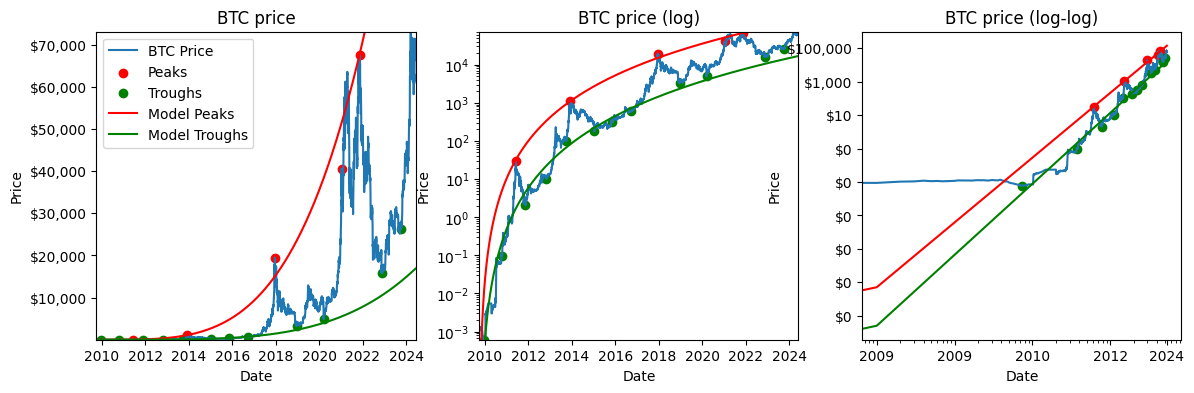

In [192]:

d_days = 300
threshold = 0.51
full_data = historical_data.copy()
# full_data = full_data.drop_duplicates('date')
full_data = full_data.drop_duplicates('date')
full_data = full_data[['date', 'btc_price']]
full_data = full_data.reset_index(drop=True)


peaks, clean_peaks = get_peaks(full_data, d_days, threshold)
troughs, clean_troughs = get_troughs(full_data, d_days, threshold)
peak_model, peak_r2 = get_power_law_model(full_data, clean_peaks)
# print('Peak model:', peak_model)
trough_model, trough_r2 = get_power_law_model(full_data, clean_troughs)
# print('Trough model:', trough_model)
fig, ax = get_frame_plot(full_data, clean_peaks, clean_troughs, peak_model, trough_model)
plt.show()


In [188]:
# we remove duplicates from full_data
full_data = historical_data.copy()
# full_data = full_data.drop_duplicates('date')
full_data = full_data.drop_duplicates('date')
full_data = full_data[['date', 'btc_price']]
full_data = full_data.reset_index(drop=True)
full_data.head()


,date,btc_price
0,2009-10-05,0.000764
1,2009-10-06,0.000885
2,2009-10-07,0.001050
3,2009-10-08,0.001084
4,2009-10-09,0.001200
